# Hierarchical model fit on Splatter datasets

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
import scipy
from utils import loadStan, hierarchical_model, est_k
sns.set()
from sklearn.metrics import adjusted_rand_score
import csv
import math
import time

ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Loading model  ppca
Model loaded succesfully from cache.
Loading model  gmm
Model loaded succesfully from cache.
Loading model  moppcas
Model loaded succesfully from cache.
Loading model  moppcas_weighted
Model loaded succesfully from cache.
Loading model  ppca_weighted
Model loaded succesfully from cache.
Loading model  gmm_weighted
Model loaded succesfully from cache.


## Comparison NUTS and VB in terms of speed and accuracy

### Dataset 1

In [6]:
timings_nuts = []
timings_vb = []
knots_nuts_try = []
knots_vb_try = []
knots_nuts_found = []
knots_vb_found = []
acc_scores_nuts = []
acc_scores_vb = []

for num_dims in [5,25, 50,150, 250]:
    print('Analyzing dataset of %i genes: '%num_dims)
    with open('./splattersets/splatter_small_%i.csv'%num_dims) as file:
        text = csv.reader(file)
        data = np.array(np.array(list(text))[1:,1:].T, dtype=int)
    with open('./splattersets/splatter_small_%i_labels.csv'%num_dims) as file:
        text = csv.reader(file)
        labels_raw = np.array(list(text))
    data = np.log(data+1)
    labels = np.unique(labels_raw[1:,1], return_inverse=True)[1]
    labelnames = ['gene '+str(i+1) for i in set(labels)]
    model = hierarchical_model()
    latent, cats_per_lvl, probs, times_vb, knots_vb_trd, knots_vb_fnd = model.fit(data, max_depth=5, k_max=3, samplingmethod='VB', plotting=False)
    timings_vb.append(times_vb)
    knots_vb_try.append(knots_vb_trd)
    knots_vb_found.append(knots_vb_fnd)
    scores_vb = model.visual_score(labels, plotlegend=True, savefigs=True, labelnames = labelnames, plot_hmppca = False, plot_hmppca_logres = False, plot_real = True, plot_logreg = True)
    acc_scores_vb.append(scores_vb)
    
    model = hierarchical_model()
    latent, cats_per_lvl, probs, times_nuts, knots_nuts_trd, knots_nuts_fnd = model.fit(data, max_depth=5, k_max=3, samplingmethod='NUTS', plotting=False)
    timings_nuts.append(times_nuts)
    knots_nuts_try.append(knots_nuts_trd)
    knots_nuts_found.append(knots_nuts_fnd)
    scores_nuts = model.visual_score(labels, plotlegend=True, savefigs=True, labelnames = labelnames, plot_hmppca = False, plot_hmppca_logres = False, plot_real = True, plot_logreg = True)
    acc_scores_nuts.append(scores_nuts)
    

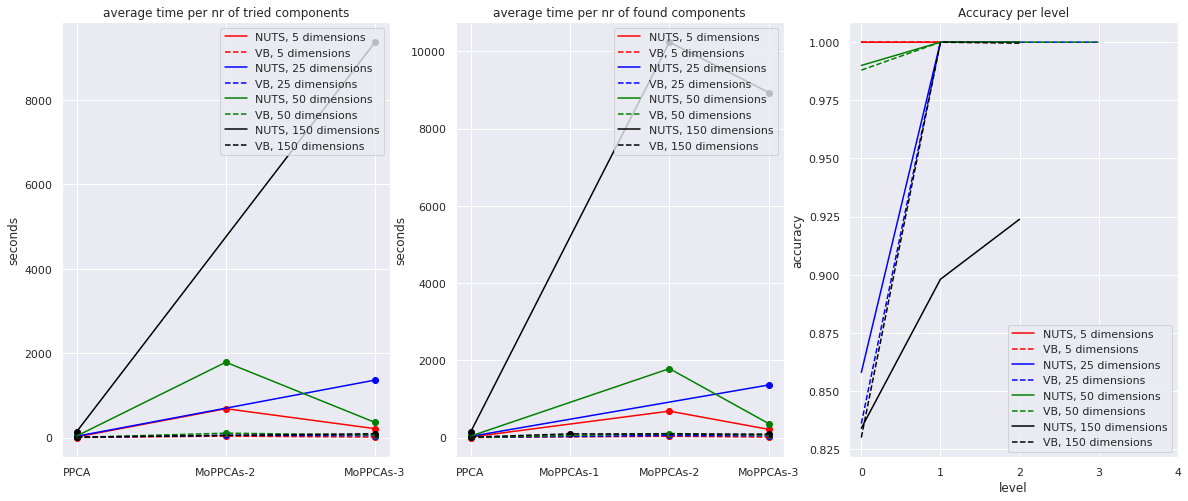

In [25]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(131)
ax.set_title('average time per nr of tried components')
for i in range(4):
    boxpoints_nuts = []
    nanindex_nuts = []
    boxpoints_vb = []
    nanindex_vb = []
    for j in [0,1,2,3]:
        if len(np.array(timings_nuts[i])[np.array(knots_nuts_try[i])==j])>0:
            boxpoints_nuts.append(np.mean(np.array(timings_nuts[i])[np.array(knots_nuts_try[i])==j]))
            nanindex_nuts.append(True)
        else:
            boxpoints_nuts.append(0)
            nanindex_nuts.append(False)
        if len(np.array(timings_vb[i])[np.array(knots_vb_try[i])==j])>0:
            boxpoints_vb.append(np.mean(np.array(timings_vb[i])[np.array(knots_vb_try[i])==j]))
            nanindex_vb.append(True)
        else:
            boxpoints_vb.append(0)
            nanindex_vb.append(False)
    nanindex_nuts = np.array(nanindex_nuts)
    boxpoints_nuts = np.array(boxpoints_nuts)
    nanindex_vb = np.array(nanindex_vb)
    boxpoints_vb = np.array(boxpoints_vb)
    ax.plot(np.array([1,1,2,3])[nanindex_nuts],boxpoints_nuts[nanindex_nuts], label='NUTS, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.scatter(np.array([1,1,2,3])[nanindex_nuts],boxpoints_nuts[nanindex_nuts], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.plot(np.array([1,1,2,3])[nanindex_vb],boxpoints_vb[nanindex_vb], label='VB, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i], linestyle='--')
    ax.scatter(np.array([1,1,2,3])[nanindex_vb],boxpoints_vb[nanindex_vb], c= ['red', 'blue', 'green', 'black', 'purple'][i])
i+=1
# ax.plot(knots_vb_found[i], timings_vb[i], label='V, %i dimensions'%[5,25, 50,150, 250][i], linestyle='--', c= ['red', 'blue', 'green', 'black', 'purple', 'purple'][i])
ax.legend(loc='upper right')
ax.set_ylabel('seconds')
# ax.set_ylim((0,2500))
ax.set_xticks([1,2,3])
ax.set_xticklabels(['PPCA','MoPPCAs-2','MoPPCAs-3'])
ax = fig.add_subplot(132)
ax.set_title('average time per nr of found components')
for i in range(4):
    boxpoints_nuts = []
    nanindex_nuts = []
    boxpoints_vb = []
    nanindex_vb = []
    for j in [0,1,2,3]:
        if len(np.array(timings_nuts[i])[np.array(knots_nuts_found[i])==j])>0:
            boxpoints_nuts.append(np.mean(np.array(timings_nuts[i])[np.array(knots_nuts_found[i])==j]))
            nanindex_nuts.append(True)
        else:
            boxpoints_nuts.append(0)
            nanindex_nuts.append(False)
        if len(np.array(timings_vb[i])[np.array(knots_vb_found[i])==j])>0:
            boxpoints_vb.append(np.mean(np.array(timings_vb[i])[np.array(knots_vb_found[i])==j]))
            nanindex_vb.append(True)
        else:
            boxpoints_vb.append(0)
            nanindex_vb.append(False)
    nanindex_nuts = np.array(nanindex_nuts)
    boxpoints_nuts = np.array(boxpoints_nuts)
    nanindex_vb = np.array(nanindex_vb)
    boxpoints_vb = np.array(boxpoints_vb)
    ax.plot(np.array([0,1,2,3])[nanindex_nuts],boxpoints_nuts[nanindex_nuts], label='NUTS, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.scatter(np.array([0,1,2,3])[nanindex_nuts],boxpoints_nuts[nanindex_nuts], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.plot(np.array([0,1,2,3])[nanindex_vb],boxpoints_vb[nanindex_vb], label='VB, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i], linestyle='--')
    ax.scatter(np.array([0,1,2,3])[nanindex_vb],boxpoints_vb[nanindex_vb], c= ['red', 'blue', 'green', 'black', 'purple'][i])
i+=1
ax.legend(loc='upper right')
ax.set_ylabel('seconds')
# ax.set_ylim((0,2500))
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['PPCA', 'MoPPCAs-1','MoPPCAs-2','MoPPCAs-3'])
ax = fig.add_subplot(133)
ax.set_title('Accuracy per level')
for i in range(4):
    ax.plot(range(len(acc_scores_nuts[i])), acc_scores_nuts[i], label='NUTS, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.plot(range(len(acc_scores_vb[i])), acc_scores_vb[i], label='VB, %i dimensions'%[5,25, 50,150, 250][i], linestyle='--', c= ['red', 'blue', 'green', 'black', 'purple'][i])
i+=1
# ax.plot(range(len(acc_scores_vb[i])), acc_scores_vb[i], label='V, %i dimensions'%[5,25, 50,150, 250][i], linestyle='--', c= ['red', 'blue', 'green', 'black', 'purple'][i])
ax.legend(loc='lower right')
ax.set_ylabel('accuracy')
ax.set_xlabel('level')
ax.set_xticks([0,1,2,3,4])
plt.savefig('time_acc_small.png')
plt.show()

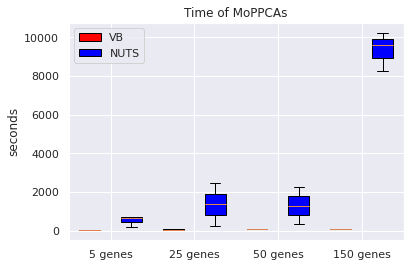

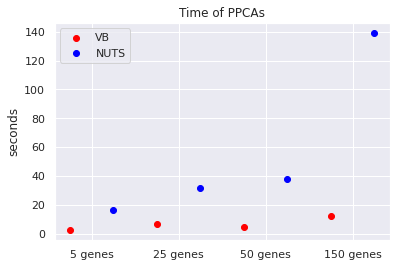

In [22]:
boxpoints = []
names = []
for i in range(4):
    boxpoints.append(timings_vb[i][1:])
    boxpoints.append(timings_nuts[i][1:])
    names.append('%i genes'%[5,25,50,150][i])
box = plt.boxplot(boxpoints, patch_artist=True)
i=0
for patch in box['boxes']:
    patch.set_facecolor(['red','blue'][i%2])
    i+=1
plt.legend(box['boxes'][:2],['VB','NUTS'])
plt.title('Time of MoPPCAs')
plt.ylabel('seconds')
plt.xticks(np.arange(1.5,len(boxpoints)+1.5,2),names)
plt.savefig('time_ppca2_small.png')
plt.show()

boxpoints_vb = []
boxpoints_nuts = []
names = []
for i in range(4):
    boxpoints_vb.append(timings_vb[i][0])
    boxpoints_nuts.append(timings_nuts[i][0])
    names.append('%i genes'%[5,25,50,150][i])
# box = plt.boxplot(boxpoints, patch_artist=True)
plt.scatter(range(1,8,2),boxpoints_vb, c='red', label='VB')
plt.scatter(range(2,9,2),boxpoints_nuts, c='blue', label='NUTS')
plt.legend()
plt.title('Time of PPCAs')
plt.ylabel('seconds')
plt.xticks(np.arange(1.5,len(boxpoints)+1.5,2),names)
plt.savefig('time_moppcas2_small.png')
plt.show()

### Dataset 2

In [19]:
timings_nuts2 = []
timings_vb2 = []
knots_nuts_try2 = []
knots_vb_try2 = []
knots_nuts_found2 = []
knots_vb_found2 = []
acc_scores_nuts2 = []
acc_scores_vb2 = []

for num_dims in [5,25, 50,150, 250]:
    print('Analyzing dataset of %i genes: '%num_dims)
    with open('./splattersets/splatter_big_%i.csv'%num_dims) as file:
        text = csv.reader(file)
        data2 = np.array(np.array(list(text))[1:,1:].T, dtype=int)
    with open('./splattersets/splatter_big_%i_labels.csv'%num_dims) as file:
        text = csv.reader(file)
        labels_raw2 = np.array(list(text))
    data2 = np.log(data2+1)
    labels2 = np.unique(labels_raw2[1:,1], return_inverse=True)[1]
    labelnames2 = ['gene '+str(i+1) for i in set(labels2)]
    model = hierarchical_model()
    latent, cats_per_lvl, probs, times_vb2, knots_vb_trd2, knots_vb_fnd2 = model.fit(data2, max_depth=5, k_max=3, samplingmethod='VB', plotting=False)
    timings_vb2.append(times_vb2)
    knots_vb_try2.append(knots_vb_trd2)
    knots_vb_found2.append(knots_vb_fnd2)
    scores_vb2 = model.visual_score(labels2, plotlegend=True, savefigs=True, labelnames = labelnames2, plot_hmppca = False, plot_hmppca_logres = False, plot_real = True, plot_logreg = True)
    acc_scores_vb2.append(scores_vb2)
    
    model = hierarchical_model()
    latent, cats_per_lvl, probs, times_nuts2, knots_nuts_trd2, knots_nuts_fnd2 = model.fit(data2, max_depth=5, k_max=3, samplingmethod='NUTS', plotting=False)
    timings_nuts2.append(times_nuts2)
    knots_nuts_try2.append(knots_nuts_trd2)
    knots_nuts_found2.append(knots_nuts_fnd2)
    scores_nuts2 = model.visual_score(labels2, plotlegend=True, savefigs=True, labelnames = labelnames2, plot_hmppca = False, plot_hmppca_logres = False, plot_real = True, plot_logreg = True)
    acc_scores_nuts2.append(scores_nuts2)
    

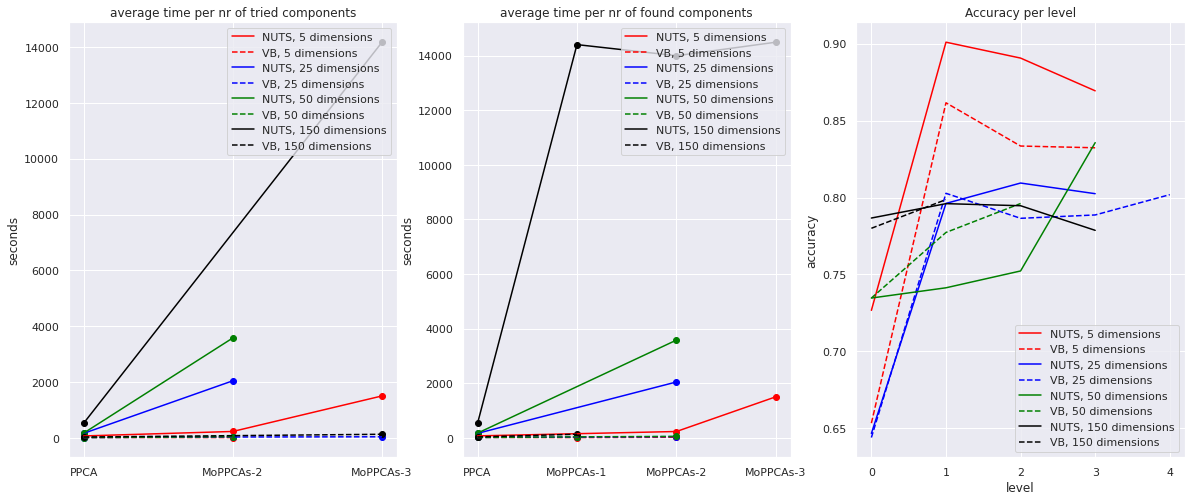

In [23]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(131)
ax.set_title('average time per nr of tried components')
for i in range(4):
    boxpoints_nuts2 = []
    nanindex_nuts2 = []
    boxpoints_vb2 = []
    nanindex_vb2 = []
    for j in [0,1,2,3]:
        if len(np.array(timings_nuts2[i])[np.array(knots_nuts_try2[i])==j])>0:
            boxpoints_nuts2.append(np.mean(np.array(timings_nuts2[i])[np.array(knots_nuts_try2[i])==j]))
            nanindex_nuts2.append(True)
        else:
            boxpoints_nuts2.append(0)
            nanindex_nuts2.append(False)
        if len(np.array(timings_vb2[i])[np.array(knots_vb_try2[i])==j])>0:
            boxpoints_vb2.append(np.mean(np.array(timings_vb2[i])[np.array(knots_vb_try2[i])==j]))
            nanindex_vb2.append(True)
        else:
            boxpoints_vb2.append(0)
            nanindex_vb2.append(False)
    nanindex_nuts2 = np.array(nanindex_nuts2)
    boxpoints_nuts2 = np.array(boxpoints_nuts2)
    nanindex_vb2 = np.array(nanindex_vb2)
    boxpoints_vb2 = np.array(boxpoints_vb2)
    ax.plot(np.array([1,1,2,3])[nanindex_nuts2],boxpoints_nuts2[nanindex_nuts2], label='NUTS, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.scatter(np.array([1,1,2,3])[nanindex_nuts2],boxpoints_nuts2[nanindex_nuts2], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.plot(np.array([1,1,2,3])[nanindex_vb2],boxpoints_vb2[nanindex_vb2], label='VB, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i], linestyle='--')
    ax.scatter(np.array([1,1,2,3])[nanindex_vb2],boxpoints_vb2[nanindex_vb2], c= ['red', 'blue', 'green', 'black', 'purple'][i])
i+=1
# ax.plot(knots_vb_found[i], timings_vb[i], label='V, %i dimensions'%[5,25, 50,150, 250][i], linestyle='--', c= ['red', 'blue', 'green', 'black', 'purple', 'purple'][i])
ax.legend(loc='upper right')
ax.set_ylabel('seconds')
# ax.set_ylim((0,2500))
ax.set_xticks([1,2,3])
ax.set_xticklabels(['PPCA','MoPPCAs-2','MoPPCAs-3'])
ax = fig.add_subplot(132)
ax.set_title('average time per nr of found components')
for i in range(4):
    boxpoints_nuts2 = []
    nanindex_nuts2 = []
    boxpoints_vb2 = []
    nanindex_vb2 = []
    for j in [0,1,2,3]:
        if len(np.array(timings_nuts2[i])[np.array(knots_nuts_found2[i])==j])>0:
            boxpoints_nuts2.append(np.mean(np.array(timings_nuts2[i])[np.array(knots_nuts_found2[i])==j]))
            nanindex_nuts2.append(True)
        else:
            boxpoints_nuts2.append(0)
            nanindex_nuts2.append(False)
        if len(np.array(timings_vb2[i])[np.array(knots_vb_found2[i])==j])>0:
            boxpoints_vb2.append(np.mean(np.array(timings_vb2[i])[np.array(knots_vb_found2[i])==j]))
            nanindex_vb2.append(True)
        else:
            boxpoints_vb2.append(0)
            nanindex_vb2.append(False)
    nanindex_nuts2 = np.array(nanindex_nuts2)
    boxpoints_nuts2 = np.array(boxpoints_nuts2)
    nanindex_vb2 = np.array(nanindex_vb2)
    boxpoints_vb2 = np.array(boxpoints_vb2)
    ax.plot(np.array([0,1,2,3])[nanindex_nuts2],boxpoints_nuts2[nanindex_nuts2], label='NUTS, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.scatter(np.array([0,1,2,3])[nanindex_nuts2],boxpoints_nuts2[nanindex_nuts2], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.plot(np.array([0,1,2,3])[nanindex_vb2],boxpoints_vb2[nanindex_vb2], label='VB, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i], linestyle='--')
    ax.scatter(np.array([0,1,2,3])[nanindex_vb2],boxpoints_vb2[nanindex_vb2], c= ['red', 'blue', 'green', 'black', 'purple'][i])
i+=1
ax.legend(loc='upper right')
ax.set_ylabel('seconds')
# ax.set_ylim((0,2500))
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['PPCA', 'MoPPCAs-1','MoPPCAs-2','MoPPCAs-3'])
ax = fig.add_subplot(133)
ax.set_title('Accuracy per level')
for i in range(4):
    ax.plot(range(len(acc_scores_nuts2[i])), acc_scores_nuts2[i], label='NUTS, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.plot(range(len(acc_scores_vb2[i])), acc_scores_vb2[i], label='VB, %i dimensions'%[5,25, 50,150, 250][i], linestyle='--', c= ['red', 'blue', 'green', 'black', 'purple'][i])
i+=1
# ax.plot(range(len(acc_scores_vb[i])), acc_scores_vb[i], label='V, %i dimensions'%[5,25, 50,150, 250][i], linestyle='--', c= ['red', 'blue', 'green', 'black', 'purple'][i])
ax.legend(loc='lower right')
ax.set_ylabel('accuracy')
ax.set_xlabel('level')
ax.set_xticks([0,1,2,3,4])
plt.savefig('time_acc_big.png')
plt.show()

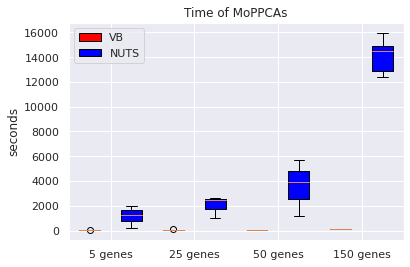

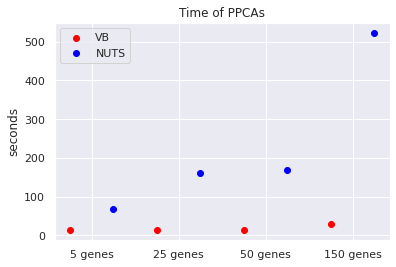

In [24]:
boxpoints2 = []
names2 = []
for i in range(4):
    boxpoints2.append(timings_vb2[i][1:])
    boxpoints2.append(timings_nuts2[i][1:])
    names2.append('%i genes'%[5,25,50,150][i])
box = plt.boxplot(boxpoints2, patch_artist=True)
i=0
for patch in box['boxes']:
    patch.set_facecolor(['red','blue'][i%2])
    i+=1
plt.legend(box['boxes'][:2],['VB','NUTS'])
plt.title('Time of MoPPCAs')
plt.ylabel('seconds')
plt.xticks(np.arange(1.5,len(boxpoints2)+1.5,2),names2)
plt.savefig('time_moppcas2_big.png')
plt.show()

boxpoints_vb2 = []
boxpoints_nuts2 = []
names2 = []
for i in range(4):
    boxpoints_vb2.append(timings_vb2[i][0])
    boxpoints_nuts2.append(timings_nuts2[i][0])
    names2.append('%i genes'%[5,25,50,150][i])
# box = plt.boxplot(boxpoints, patch_artist=True)
plt.scatter(range(1,8,2),boxpoints_vb2, c='red', label='VB')
plt.scatter(range(2,9,2),boxpoints_nuts2, c='blue', label='NUTS')
plt.legend()
plt.title('Time of PPCAs')
plt.ylabel('seconds')
plt.xticks(np.arange(1.5,len(boxpoints2)+1.5,2),names2)
plt.savefig('time_ppca2_big.png')
plt.show()